In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = pathlib.Path("faces")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4072


In [20]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4072 files belonging to 3 classes.
Using 3258 files for training.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4072 files belonging to 3 classes.
Using 814 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['mask_weared_incorrect', 'with_mask', 'without_mask']


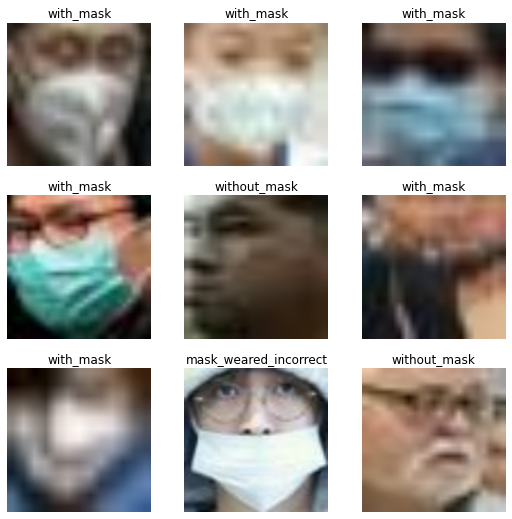

In [23]:
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(9):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)

num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

32
32
32
32
32
32
32
32
32


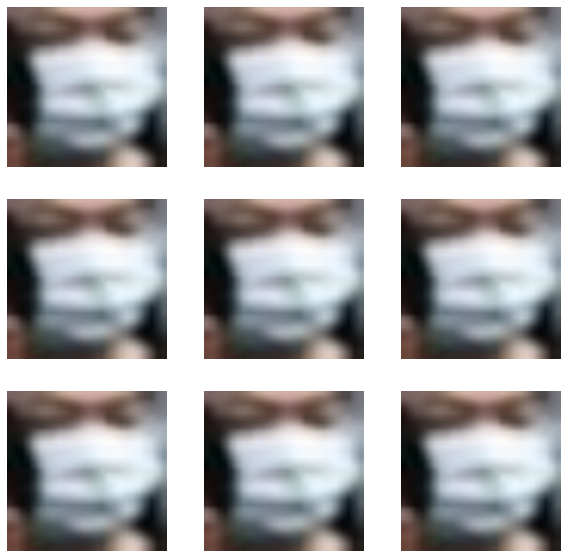

In [33]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    print(len(augmented_images))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/15
 50/102 [=============>................] - ETA: 17s - loss: 0.3582 - accuracy: 0.8813

KeyboardInterrupt: 

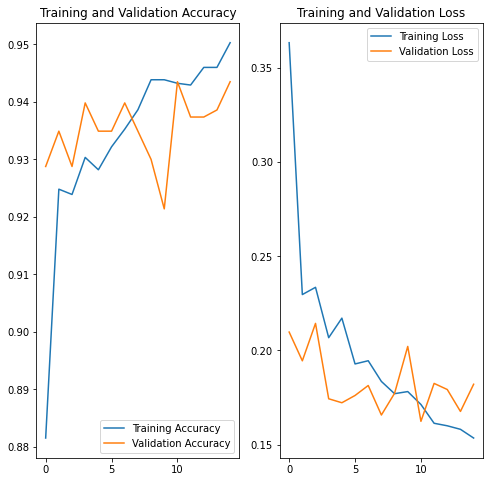

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
testing_images = glob.glob('./testing/*.*')

for test_image in testing_images:
    image_path = pathlib.Path(test_image)

    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(test_image)
    print(class_names)
    print(score)
    print(np.argmax(score))
    print(
        "{} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('---------------------------------------')

./testing/4.png
['mask_weared_incorrect', 'with_mask', 'without_mask']
tf.Tensor([0.39756078 0.5065496  0.09588961], shape=(3,), dtype=float32)
1
with_mask with a 50.65 percent confidence.
---------------------------------------
./testing/5.jpg
['mask_weared_incorrect', 'with_mask', 'without_mask']
tf.Tensor([4.4954902e-01 5.5045056e-01 4.8059883e-07], shape=(3,), dtype=float32)
1
with_mask with a 55.05 percent confidence.
---------------------------------------
./testing/6.png
['mask_weared_incorrect', 'with_mask', 'without_mask']
tf.Tensor([0.33243805 0.09319095 0.574371  ], shape=(3,), dtype=float32)
2
without_mask with a 57.44 percent confidence.
---------------------------------------
./testing/2.png
['mask_weared_incorrect', 'with_mask', 'without_mask']
tf.Tensor([0.0275993  0.94676214 0.02563859], shape=(3,), dtype=float32)
1
with_mask with a 94.68 percent confidence.
---------------------------------------
./testing/3.jpg
['mask_weared_incorrect', 'with_mask', 'without_mask']
t